In [1]:
import numpy as np
import bilby
import gwpy
import sys
sys.path.insert(0,'..')
import pygwb.util
from pygwb.simulator import Simulator
from scipy import optimize

# Simple injection & recovery test with simulator module 
## see also generate_stochastic_background_in_network for details

## set up of the simulation
###  create spectrum to inject

In [ ]:
frequencies_x = np.linspace(0, 1000, 10000)

alpha1 = 6
alpha2 = 0
fref = 10
omegaRef = 5.e-5

def IntensityGW(freqs, omegaRef, alpha1, fref, alpha2 = 2/3):
    ''' GW Intensity function from broken power law in OmegaGW '''
    '''
    
    PARAMETERS
    freqs: np.array
        frequency array
    fref: 
        reference frequency
    omegaRef: 
        Value of OmegaGW at reference frequency
    alpha1:
        first spectral index
    alpha2:
        second spectral index
        
    RETURN
    FrequencySeries
    
    '''
    from pygwb.constants import H0
    H_theor = (3 * H0 ** 2) / (10 * np.pi ** 2)
    
    fknee = fref
    
    power = np.zeros_like(freqs)
    
    power[freqs<fknee] = H_theor * omegaRef * (freqs[freqs<fknee]) ** (alpha1 -3) * fref**(-alpha1)
    power[freqs>fknee] = H_theor * omegaRef * (freqs[freqs>fknee]) ** (alpha2 - 3) * fref**(-alpha2)
    power[freqs==fknee] = H_theor * omegaRef * (fknee) ** (alpha2 -3) * fref**(-alpha2)
    
    #power[freqs<10.]= omegaRef * (10. / fref) ** alpha1
    power[0] = power[1]
    
    return gwpy.frequencyseries.FrequencySeries(power, frequencies=freqs)

Intensity_GW_inject = IntensityGW(frequencies_x, omegaRef = omegaRef, alpha1 = alpha1, fref = fref)

### simulation parameters

In [9]:
duration = 60
# duration of each segment of data (s)
N_segs = 5
# number of data segments to generate
sampling_frequency = 1024
# Hz

### set up interferometers

In [8]:
ifo_H1 = bilby.gw.detector.get_empty_interferometer('H1')
ifo_L1 = bilby.gw.detector.get_empty_interferometer('L1')

ifo_list = [ifo_H1, ifo_L1]

for ifo in ifo_list:
    ifo.duration = duration
    ifo.sampling_frequency = sampling_frequency
    ifo.power_spectral_density = bilby.gw.detector.PowerSpectralDensity(ifo.frequency_array, np.nan_to_num(ifo.power_spectral_density_array, posinf=1.e-41))
    
simulator_1 = Simulator(ifo_list, Intensity_GW_inject, N_segs, duration = duration, sampling_frequency = sampling_frequency)

## run the recovery test

In [12]:
#Function to fit the data to
def func(x,a,b):
    return 10**(a*np.log10(x)+b)

In [10]:
Ntests=200

psd_array_H1=np.zeros(Ntests, dtype=gwpy.frequencyseries.FrequencySeries)
# psd_array_L1=np.zeros(Ntests)

# spectral_array=np.zeros(Ntests)
# intercept_array=np.zeros(Ntests)
# mask1=(frequencies>20)&(frequencies<200)

for ii in range(Ntests):
    simulator_1 = Simulator(ifo_list, Intensity_GW_inject, N_segments = N_segs, duration = duration, sampling_frequency = sampling_frequency)
    dataset = simulator_1.generate_data()
    data_H1, data_L1 = dataset
    
    psd_array_H1[ii]=data_H1.psd()

H1:SIM-STOCH_INJ
L1:SIM-STOCH_INJ
H1:SIM-STOCH_INJ
L1:SIM-STOCH_INJ
H1:SIM-STOCH_INJ
L1:SIM-STOCH_INJ
H1:SIM-STOCH_INJ
L1:SIM-STOCH_INJ
H1:SIM-STOCH_INJ
L1:SIM-STOCH_INJ
H1:SIM-STOCH_INJ
L1:SIM-STOCH_INJ
H1:SIM-STOCH_INJ
L1:SIM-STOCH_INJ
H1:SIM-STOCH_INJ
L1:SIM-STOCH_INJ
H1:SIM-STOCH_INJ
L1:SIM-STOCH_INJ
H1:SIM-STOCH_INJ
L1:SIM-STOCH_INJ
H1:SIM-STOCH_INJ
L1:SIM-STOCH_INJ
H1:SIM-STOCH_INJ
L1:SIM-STOCH_INJ
H1:SIM-STOCH_INJ
L1:SIM-STOCH_INJ
H1:SIM-STOCH_INJ
L1:SIM-STOCH_INJ
H1:SIM-STOCH_INJ
L1:SIM-STOCH_INJ
H1:SIM-STOCH_INJ
L1:SIM-STOCH_INJ
H1:SIM-STOCH_INJ
L1:SIM-STOCH_INJ
H1:SIM-STOCH_INJ
L1:SIM-STOCH_INJ
H1:SIM-STOCH_INJ
L1:SIM-STOCH_INJ
H1:SIM-STOCH_INJ
L1:SIM-STOCH_INJ
H1:SIM-STOCH_INJ
L1:SIM-STOCH_INJ
H1:SIM-STOCH_INJ
L1:SIM-STOCH_INJ
H1:SIM-STOCH_INJ
L1:SIM-STOCH_INJ
H1:SIM-STOCH_INJ
L1:SIM-STOCH_INJ
H1:SIM-STOCH_INJ
L1:SIM-STOCH_INJ
H1:SIM-STOCH_INJ
L1:SIM-STOCH_INJ
H1:SIM-STOCH_INJ
L1:SIM-STOCH_INJ
H1:SIM-STOCH_INJ
L1:SIM-STOCH_INJ
H1:SIM-STOCH_INJ
L1:SIM-STOCH_INJ
H1:SIM-STOCH_I

In [13]:
freqs_1=psd_array_H1[0].frequencies.value
mask_1=(freqs_1>25)&(freqs_1<100)

psd_average=np.zeros(psd_array_H1[0].frequencies.value.shape)
# psd_array_L1=np.zeros(Ntests)

# spectral_array=np.zeros(Ntests)
# intercept_array=np.zeros(Ntests)
# mask1=(frequencies>20)&(frequencies<200)

for ii in range(Ntests):
    psd_average+=1/Ntests*psd_array_H1[ii].value

popt,pcov=optimize.curve_fit(func,freqs_1[mask_1],psd_average[mask_1])

spectral_avg=popt[0]
intercept_avg=popt[1]

In [14]:
from pygwb.constants import H0
H_theor = (3 * H0 ** 2) / (10 * np.pi ** 2)

omegaRef_avg=func(fref,spectral_avg,intercept_avg)/H_theor*fref**3

print(f"fit spectral index from PSD average: {spectral_avg}")
print(f"fit Omega(fref) from PSD average: {omegaRef_avg}")
print(f"% difference between spectral indices: {100*np.abs((spectral_avg-(2/3-3))/(2/3-3))}")
print(f"% difference between Omega(fref): {100*np.abs(omegaRef-omegaRef_avg)/omegaRef}")

fit spectral index from PSD average: -2.314222600008697
fit Omega(fref) from PSD average: 5.328944316698388e-05
% difference between spectral indices: 0.8190314281987083
% difference between Omega(fref): 6.578886333967758


Text(0, 0.5, 'PSD')

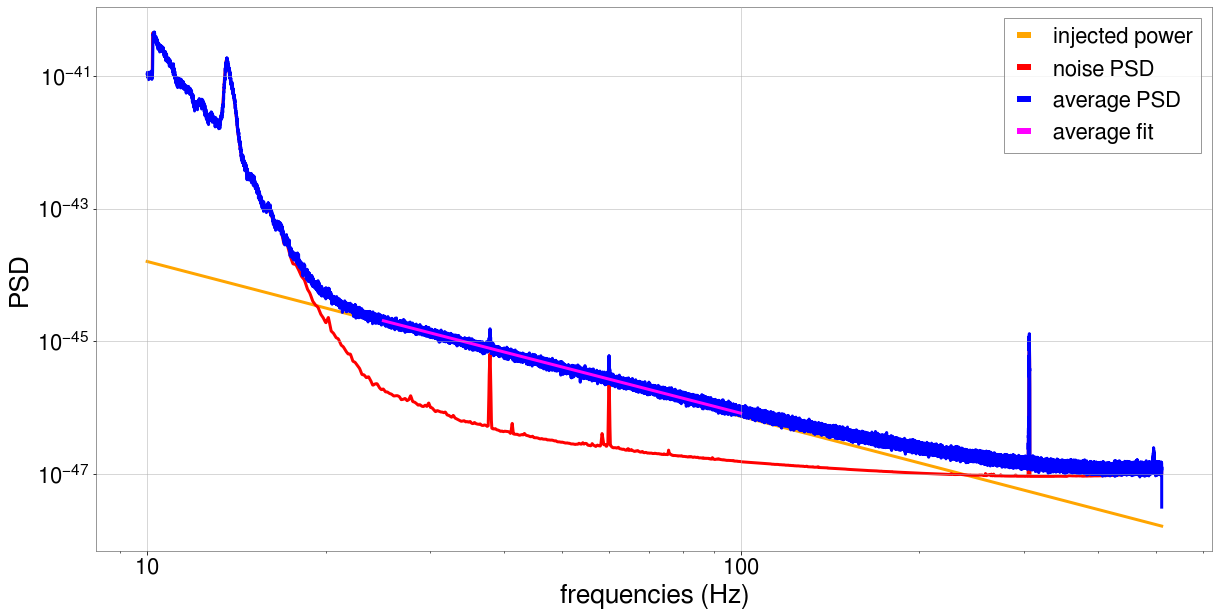

In [25]:
mask_2 = (freqs_1>10)&(freqs_1<freqs_1[-1])
mask_3 = (Intensity_GW_inject.frequencies.value>10)&(Intensity_GW_inject.frequencies.value<freqs_1[-1]) 
mask_4 = (ifo_H1.power_spectral_density.frequency_array>10)&(ifo_H1.power_spectral_density.frequency_array<freqs_1[-1]) 

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams.update({'font.size': 22})
ax, fig = plt.subplots(figsize = (20,10))
plt.loglog(Intensity_GW_inject.frequencies.value[mask_3], Intensity_GW_inject.value[mask_3], linewidth = 3, label = 'injected power',color='orange')
plt.loglog(ifo_H1.power_spectral_density.frequency_array[mask_4], ifo_H1.power_spectral_density.psd_array[mask_4], linewidth = 3, color = 'red', label = 'noise PSD')
plt.loglog(freqs_1[mask_2], psd_average[mask_2], linewidth = 3, color = 'blue', label = 'average PSD')
plt.loglog(freqs_1[mask_1], func(freqs_1[mask_1],spectral_avg,intercept_avg), linewidth = 3, color = 'magenta', label = 'average fit')
plt.legend()
plt.xlabel('frequencies (Hz)')
plt.ylabel('PSD')